# WEEK4: Your First DCGAN

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,Activation, Dense, Flatten, BatchNormalization, Dense, Dropout, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

## Generator

In [3]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    # Your code here
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    # Your code here
    # BEGIN
    model.add(Conv2DTranspose(64, kernel_size=5, strides=1, padding='same'))
    # END

    # Batch normalization
    # Your code here
    # BEGIN
    model.add(BatchNormalization())
    # END

    # Leaky ReLU activation
    # Your code here
    # BEGIN
    model.add(LeakyReLU(alpha=0.01))
    # END

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    # Your code here
    # BEGIN
    model.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'))
    # END

    # Output layer with tanh activation
    # Your code here
    # BEGIN
    model.add(Activation('tanh'))
    # END

    return model

## Discriminator

In [4]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    # Your code here
    # BEGIN
    model.add(
      Conv2D(128,
              kernel_size=3,
              strides=2,
              input_shape=img_shape,
              padding='same'))
    # END

    # Batch normalization
    # Your code here
    # BEGIN
    model.add(BatchNormalization())
    # END

    # Leaky ReLU activation
    # Your code here
    # BEGIN
    model.add(LeakyReLU(alpha=0.01))
    # END

    # Output layer with sigmoid activation
    # Your code here
    # BEGIN
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # END

    return model

## Build the Model

In [5]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [6]:
optimizer = Adam(lr=0.0002, beta_1=0.5)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def emd(a,b):
    return tf.math.reduce_mean(tf.cast(a,tf.float32)-tf.cast(b,tf.float32))

def build_models(use_tf2=False):

    # Build and compile the Discriminator
    discriminator = build_discriminator(img_shape)
    # Build the Generator
    generator = build_generator( z_dim)
    gan = build_gan(generator, discriminator)

    if use_tf2==False:
        discriminator.compile(loss=bce,
                          optimizer=optimizer,
                          metrics=['accuracy'])
        # Keep Discriminator’s parameters constant for Generator training
        discriminator.trainable = False
        # Build and compile GAN model with fixed Discriminator to train the Generator
        gan.compile(loss=bce, optimizer=optimizer)
    return discriminator, generator, gan

In [7]:
# 
def accuracy(labels, logits):
    logits=tf.concat([tf.ones_like(logits)*0.5,logits],1)
    p=tf.argmax(logits, axis=1)
    p=tf.cast(p,tf.float64)
    labels=tf.reshape(labels,[-1])
    acc=tf.reduce_sum(tf.cast(tf.equal(labels, p),tf.float64))
    return acc/logits.shape[0]

# This annotation causes the function to be "compiled".
@tf.function
def train_D(model,images, labels):
    with tf.GradientTape() as tape:
      logits = model(images, training=True)
      #print(logits.shape)
      loss = bce(labels, logits)
    gradients= tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc=accuracy(labels, logits)
    return loss,acc
@tf.function
def train_G(D_model,G_model,z, labels):
    with tf.GradientTape() as tape:
      images=G_model(z)
      logits = D_model(images, training=True)
      loss = bce(labels, logits)
    gradients= tape.gradient(loss, G_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, G_model.trainable_variables))
    return loss

In [8]:
use_tf2=True
discriminator, generator, gan = build_models(use_tf2=use_tf2)


In [9]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)       

## Training

In [10]:
losses = []
accuracies = []
r_accuracies = []
f_accuracies = []
r_loss = []
f_loss = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval,use_tf2=False):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))
    start = time.time()

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))

        # Train Discriminator
        if use_tf2:
            gen_imgs = generator(z)
            d_loss_real,d_acc_real = train_D(discriminator,imgs, real)
            d_loss_fake,d_acc_fake = train_D(discriminator,gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            accuracy = 0.5 * np.add(d_acc_real, d_acc_fake)
        else:
            gen_imgs = generator.predict(z)
            d_loss_real,d_acc_real = discriminator.train_on_batch(imgs, real)
            d_loss_fake,d_acc_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            accuracy = 0.5 * np.add(d_acc_real, d_acc_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))

        # Train Generator
        if use_tf2:
            g_loss = train_G(discriminator, generator, z, real)
        else:
            g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            r_loss.append(d_loss_real)
            f_loss.append(d_loss_fake)
            accuracies.append(100.0 * accuracy)
            r_accuracies.append(100.0 * d_acc_real)
            f_accuracies.append(100.0 * d_acc_fake)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, r_loss: %f, f_loss: %f, acc.: %.2f%%, real_acc:%.2f%%, fake_acc:%.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, d_loss_real, d_loss_fake, 100.0 * accuracy, 100.0 * d_acc_real, 100.0 * d_acc_fake, g_loss))

            # Output a sample of generated image
            sample_images(generator)
            print ('Time for interval {} is {} sec'.format((iteration + 1)//sample_interval, time.time()-start))
            start = time.time()


In [11]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    if use_tf2:
        gen_imgs = generator(z)
#    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

## Train the GAN and Inspect Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

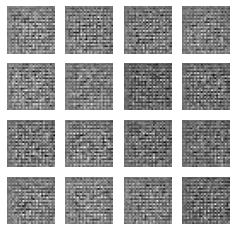

In [12]:
sample_images(generator)

100 [D loss: 0.544293, r_loss: 0.575155, f_loss: 0.513430, acc.: 74.61%, real_acc:70.31%, fake_acc:78.91%] [G loss: 2.444172]


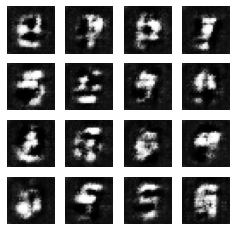

Time for interval 1 is 8.727209568023682 sec
200 [D loss: 0.525446, r_loss: 0.555275, f_loss: 0.495618, acc.: 81.64%, real_acc:78.91%, fake_acc:84.38%] [G loss: 1.292377]


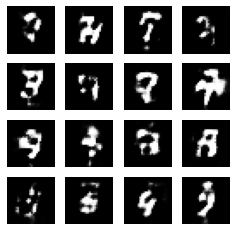

Time for interval 2 is 6.288370370864868 sec
300 [D loss: 0.448255, r_loss: 0.448709, f_loss: 0.447800, acc.: 83.20%, real_acc:81.25%, fake_acc:85.16%] [G loss: 1.580648]


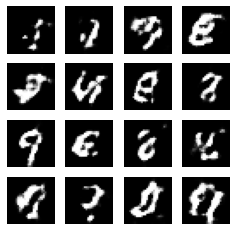

Time for interval 3 is 6.484104871749878 sec
400 [D loss: 0.545751, r_loss: 0.509398, f_loss: 0.582103, acc.: 75.00%, real_acc:75.78%, fake_acc:74.22%] [G loss: 1.421219]


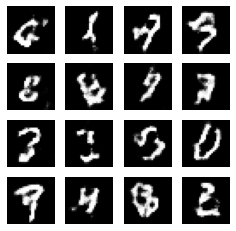

Time for interval 4 is 6.306669235229492 sec
500 [D loss: 0.578369, r_loss: 0.572200, f_loss: 0.584538, acc.: 71.09%, real_acc:72.66%, fake_acc:69.53%] [G loss: 1.213473]


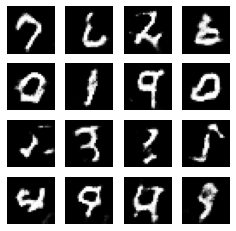

Time for interval 5 is 6.256612062454224 sec
600 [D loss: 0.573392, r_loss: 0.591269, f_loss: 0.555515, acc.: 73.83%, real_acc:69.53%, fake_acc:78.12%] [G loss: 1.244092]


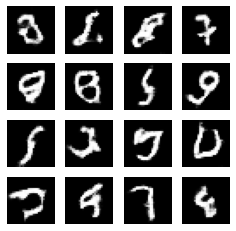

Time for interval 6 is 6.3293585777282715 sec
700 [D loss: 0.571041, r_loss: 0.565525, f_loss: 0.576557, acc.: 70.31%, real_acc:70.31%, fake_acc:70.31%] [G loss: 1.296137]


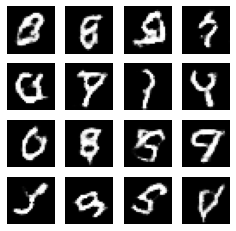

Time for interval 7 is 6.475560426712036 sec
800 [D loss: 0.582523, r_loss: 0.502921, f_loss: 0.662126, acc.: 73.44%, real_acc:83.59%, fake_acc:63.28%] [G loss: 1.162788]


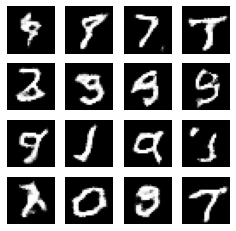

Time for interval 8 is 6.266925096511841 sec
900 [D loss: 0.544307, r_loss: 0.534390, f_loss: 0.554223, acc.: 75.78%, real_acc:77.34%, fake_acc:74.22%] [G loss: 1.285237]


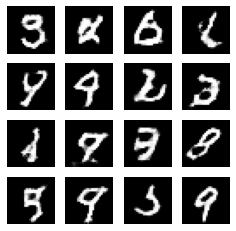

Time for interval 9 is 6.390710353851318 sec
1000 [D loss: 0.526211, r_loss: 0.543583, f_loss: 0.508839, acc.: 79.30%, real_acc:78.12%, fake_acc:80.47%] [G loss: 1.168236]


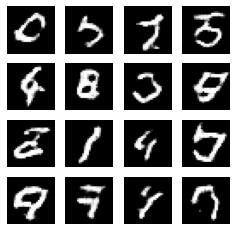

Time for interval 10 is 6.586329698562622 sec
1100 [D loss: 0.550884, r_loss: 0.583754, f_loss: 0.518014, acc.: 75.00%, real_acc:71.88%, fake_acc:78.12%] [G loss: 1.291133]


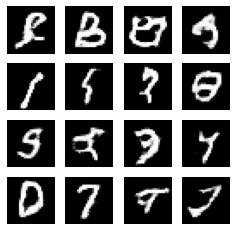

Time for interval 11 is 6.386466026306152 sec
1200 [D loss: 0.495880, r_loss: 0.508692, f_loss: 0.483067, acc.: 80.08%, real_acc:75.00%, fake_acc:85.16%] [G loss: 1.176708]


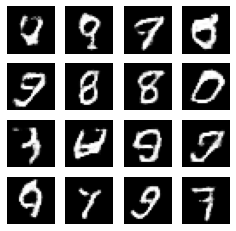

Time for interval 12 is 6.355680465698242 sec
1300 [D loss: 0.554859, r_loss: 0.570406, f_loss: 0.539312, acc.: 75.39%, real_acc:73.44%, fake_acc:77.34%] [G loss: 1.293146]


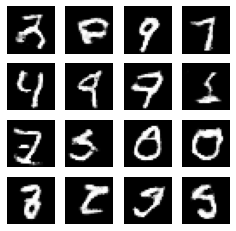

Time for interval 13 is 6.374070882797241 sec
1400 [D loss: 0.530178, r_loss: 0.570989, f_loss: 0.489366, acc.: 77.34%, real_acc:68.75%, fake_acc:85.94%] [G loss: 1.249200]


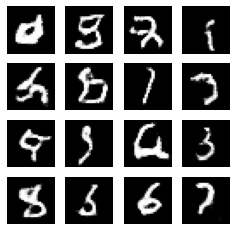

Time for interval 14 is 6.467051029205322 sec
1500 [D loss: 0.555199, r_loss: 0.548728, f_loss: 0.561669, acc.: 71.48%, real_acc:77.34%, fake_acc:65.62%] [G loss: 1.262168]


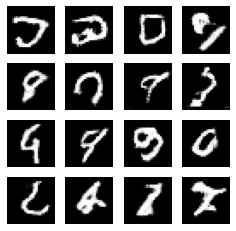

Time for interval 15 is 6.386287212371826 sec
1600 [D loss: 0.525853, r_loss: 0.594199, f_loss: 0.457507, acc.: 78.52%, real_acc:71.88%, fake_acc:85.16%] [G loss: 1.248208]


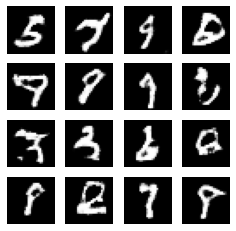

Time for interval 16 is 6.394709348678589 sec
1700 [D loss: 0.465945, r_loss: 0.425733, f_loss: 0.506156, acc.: 82.81%, real_acc:86.72%, fake_acc:78.91%] [G loss: 1.406039]


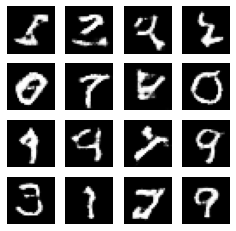

Time for interval 17 is 6.533206939697266 sec
1800 [D loss: 0.502230, r_loss: 0.539214, f_loss: 0.465245, acc.: 80.86%, real_acc:75.78%, fake_acc:85.94%] [G loss: 1.314891]


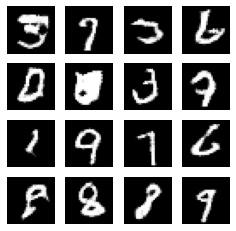

Time for interval 18 is 6.4279303550720215 sec
1900 [D loss: 0.546142, r_loss: 0.541981, f_loss: 0.550303, acc.: 75.00%, real_acc:73.44%, fake_acc:76.56%] [G loss: 1.222305]


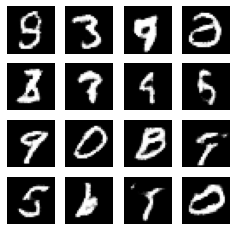

Time for interval 19 is 6.464345932006836 sec
2000 [D loss: 0.477236, r_loss: 0.460741, f_loss: 0.493732, acc.: 82.81%, real_acc:83.59%, fake_acc:82.03%] [G loss: 1.233973]


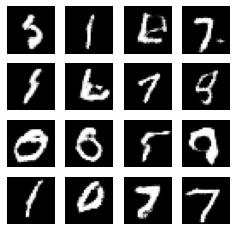

Time for interval 20 is 6.453566312789917 sec
2100 [D loss: 0.485218, r_loss: 0.479949, f_loss: 0.490486, acc.: 82.03%, real_acc:82.03%, fake_acc:82.03%] [G loss: 1.352077]


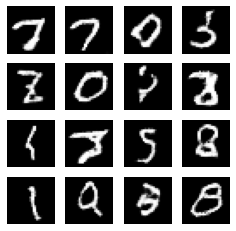

Time for interval 21 is 6.626748561859131 sec
2200 [D loss: 0.513265, r_loss: 0.541837, f_loss: 0.484693, acc.: 76.95%, real_acc:74.22%, fake_acc:79.69%] [G loss: 1.363145]


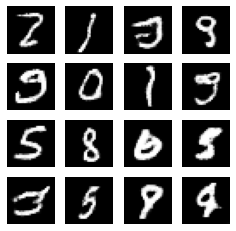

Time for interval 22 is 6.5139710903167725 sec
2300 [D loss: 0.478060, r_loss: 0.488781, f_loss: 0.467339, acc.: 80.86%, real_acc:78.91%, fake_acc:82.81%] [G loss: 1.277397]


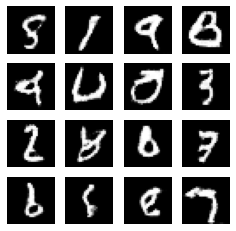

Time for interval 23 is 6.445994853973389 sec
2400 [D loss: 0.507807, r_loss: 0.548355, f_loss: 0.467259, acc.: 76.56%, real_acc:69.53%, fake_acc:83.59%] [G loss: 1.357048]


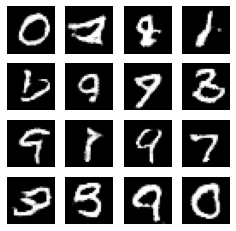

Time for interval 24 is 6.556901454925537 sec
2500 [D loss: 0.531813, r_loss: 0.507918, f_loss: 0.555707, acc.: 76.56%, real_acc:82.03%, fake_acc:71.09%] [G loss: 1.422756]


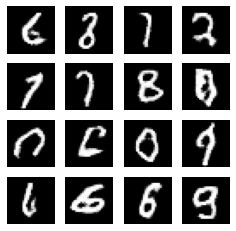

Time for interval 25 is 6.433911323547363 sec
2600 [D loss: 0.489539, r_loss: 0.479345, f_loss: 0.499733, acc.: 84.77%, real_acc:85.94%, fake_acc:83.59%] [G loss: 1.461924]


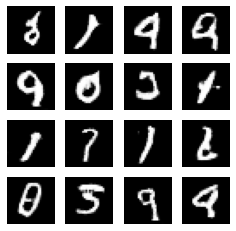

Time for interval 26 is 6.518782138824463 sec
2700 [D loss: 0.510208, r_loss: 0.585178, f_loss: 0.435239, acc.: 77.73%, real_acc:68.75%, fake_acc:86.72%] [G loss: 1.494631]


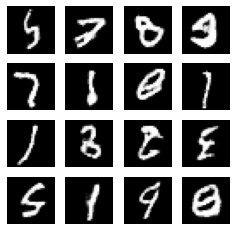

Time for interval 27 is 6.477576494216919 sec
2800 [D loss: 0.465415, r_loss: 0.477792, f_loss: 0.453037, acc.: 82.42%, real_acc:78.12%, fake_acc:86.72%] [G loss: 1.593412]


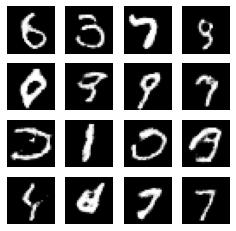

Time for interval 28 is 6.561017751693726 sec
2900 [D loss: 0.477076, r_loss: 0.479917, f_loss: 0.474236, acc.: 82.03%, real_acc:82.03%, fake_acc:82.03%] [G loss: 1.551897]


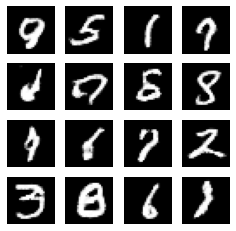

Time for interval 29 is 6.447705268859863 sec
3000 [D loss: 0.461049, r_loss: 0.461946, f_loss: 0.460152, acc.: 80.47%, real_acc:81.25%, fake_acc:79.69%] [G loss: 1.494462]


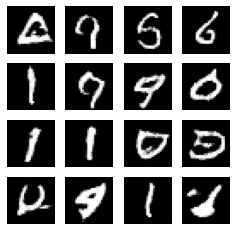

Time for interval 30 is 6.504472494125366 sec
3100 [D loss: 0.522852, r_loss: 0.500877, f_loss: 0.544828, acc.: 73.83%, real_acc:78.12%, fake_acc:69.53%] [G loss: 1.405978]


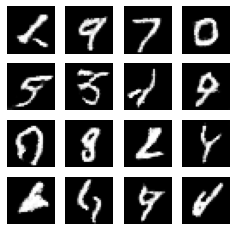

Time for interval 31 is 6.716842889785767 sec
3200 [D loss: 0.511640, r_loss: 0.562811, f_loss: 0.460468, acc.: 75.39%, real_acc:71.09%, fake_acc:79.69%] [G loss: 1.523668]


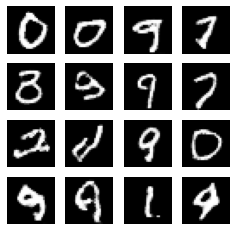

Time for interval 32 is 6.496955871582031 sec
3300 [D loss: 0.553642, r_loss: 0.485481, f_loss: 0.621804, acc.: 74.61%, real_acc:83.59%, fake_acc:65.62%] [G loss: 1.401789]


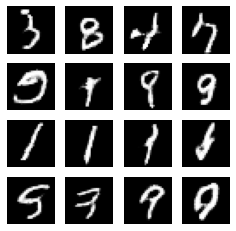

Time for interval 33 is 6.618986368179321 sec
3400 [D loss: 0.356431, r_loss: 0.341504, f_loss: 0.371357, acc.: 91.80%, real_acc:94.53%, fake_acc:89.06%] [G loss: 1.717226]


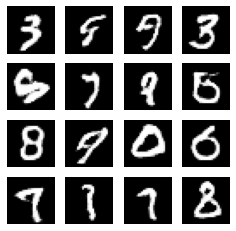

Time for interval 34 is 6.646639108657837 sec
3500 [D loss: 0.360279, r_loss: 0.360096, f_loss: 0.360463, acc.: 89.84%, real_acc:87.50%, fake_acc:92.19%] [G loss: 1.756086]


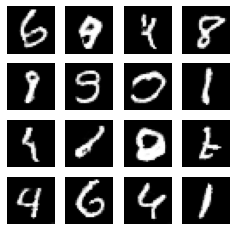

Time for interval 35 is 6.5848424434661865 sec
3600 [D loss: 0.396963, r_loss: 0.470715, f_loss: 0.323211, acc.: 86.72%, real_acc:81.25%, fake_acc:92.19%] [G loss: 1.753730]


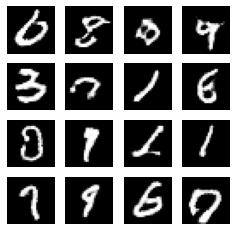

Time for interval 36 is 6.470178604125977 sec
3700 [D loss: 0.457461, r_loss: 0.431720, f_loss: 0.483202, acc.: 80.47%, real_acc:84.38%, fake_acc:76.56%] [G loss: 1.613152]


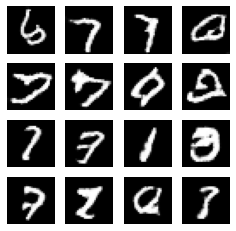

Time for interval 37 is 6.526321649551392 sec
3800 [D loss: 0.518995, r_loss: 0.480534, f_loss: 0.557455, acc.: 75.00%, real_acc:76.56%, fake_acc:73.44%] [G loss: 1.753336]


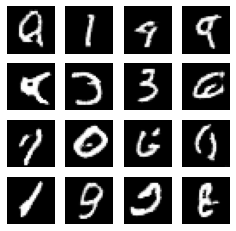

Time for interval 38 is 6.555778503417969 sec
3900 [D loss: 0.480240, r_loss: 0.429823, f_loss: 0.530658, acc.: 78.12%, real_acc:85.16%, fake_acc:71.09%] [G loss: 1.680356]


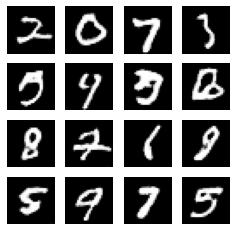

Time for interval 39 is 6.6576759815216064 sec
4000 [D loss: 0.410740, r_loss: 0.386926, f_loss: 0.434554, acc.: 85.55%, real_acc:89.06%, fake_acc:82.03%] [G loss: 1.811828]


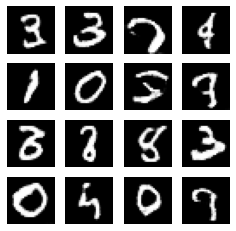

Time for interval 40 is 6.54107666015625 sec
4100 [D loss: 0.437509, r_loss: 0.451485, f_loss: 0.423533, acc.: 84.38%, real_acc:82.03%, fake_acc:86.72%] [G loss: 1.858381]


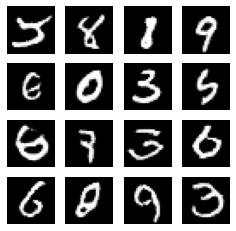

Time for interval 41 is 6.63594126701355 sec
4200 [D loss: 0.348280, r_loss: 0.461950, f_loss: 0.234609, acc.: 89.06%, real_acc:81.25%, fake_acc:96.88%] [G loss: 1.626659]


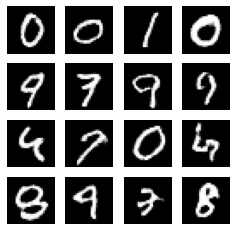

Time for interval 42 is 6.7471630573272705 sec
4300 [D loss: 0.342477, r_loss: 0.274800, f_loss: 0.410154, acc.: 92.97%, real_acc:96.09%, fake_acc:89.84%] [G loss: 1.858742]


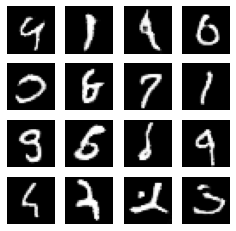

Time for interval 43 is 6.559038162231445 sec
4400 [D loss: 0.379995, r_loss: 0.344328, f_loss: 0.415662, acc.: 89.45%, real_acc:93.75%, fake_acc:85.16%] [G loss: 1.851512]


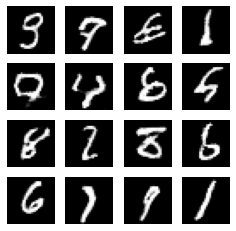

Time for interval 44 is 6.526355266571045 sec
4500 [D loss: 0.347409, r_loss: 0.439918, f_loss: 0.254900, acc.: 91.41%, real_acc:85.94%, fake_acc:96.88%] [G loss: 2.625255]


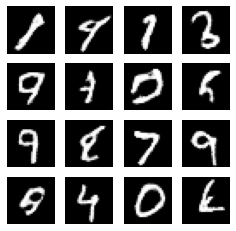

Time for interval 45 is 6.850413084030151 sec
4600 [D loss: 0.462287, r_loss: 0.532954, f_loss: 0.391619, acc.: 81.25%, real_acc:72.66%, fake_acc:89.84%] [G loss: 1.523152]


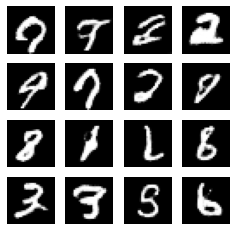

Time for interval 46 is 6.666149377822876 sec
4700 [D loss: 0.398838, r_loss: 0.409489, f_loss: 0.388187, acc.: 87.50%, real_acc:88.28%, fake_acc:86.72%] [G loss: 1.675002]


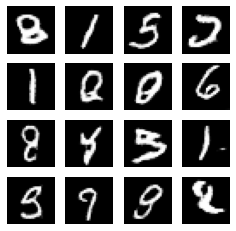

Time for interval 47 is 6.508600234985352 sec
4800 [D loss: 0.415154, r_loss: 0.372999, f_loss: 0.457309, acc.: 83.20%, real_acc:86.72%, fake_acc:79.69%] [G loss: 1.875158]


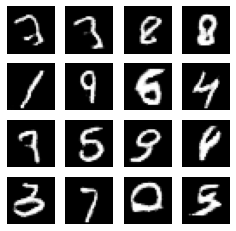

Time for interval 48 is 6.752383708953857 sec
4900 [D loss: 0.418215, r_loss: 0.319071, f_loss: 0.517360, acc.: 83.98%, real_acc:93.75%, fake_acc:74.22%] [G loss: 2.148440]


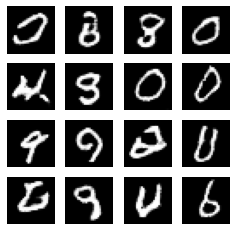

Time for interval 49 is 6.727236032485962 sec
5000 [D loss: 0.391345, r_loss: 0.399751, f_loss: 0.382939, acc.: 86.72%, real_acc:85.16%, fake_acc:88.28%] [G loss: 1.629102]


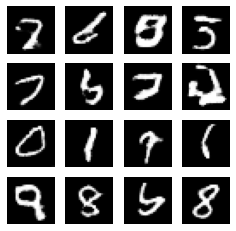

Time for interval 50 is 6.502102613449097 sec
5100 [D loss: 0.330914, r_loss: 0.264914, f_loss: 0.396913, acc.: 91.02%, real_acc:95.31%, fake_acc:86.72%] [G loss: 1.738429]


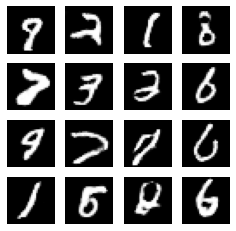

Time for interval 51 is 6.440356492996216 sec
5200 [D loss: 0.356043, r_loss: 0.372237, f_loss: 0.339850, acc.: 89.06%, real_acc:88.28%, fake_acc:89.84%] [G loss: 1.715436]


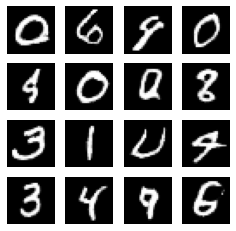

Time for interval 52 is 6.555615186691284 sec
5300 [D loss: 0.334842, r_loss: 0.261604, f_loss: 0.408080, acc.: 87.89%, real_acc:94.53%, fake_acc:81.25%] [G loss: 1.834217]


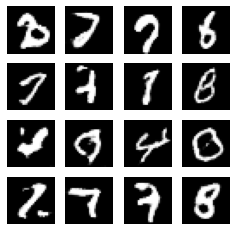

Time for interval 53 is 6.48531699180603 sec
5400 [D loss: 0.421972, r_loss: 0.366179, f_loss: 0.477765, acc.: 84.38%, real_acc:89.84%, fake_acc:78.91%] [G loss: 1.942186]


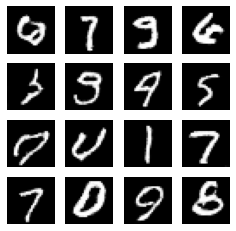

Time for interval 54 is 6.4950339794158936 sec
5500 [D loss: 0.404372, r_loss: 0.383337, f_loss: 0.425408, acc.: 85.16%, real_acc:88.28%, fake_acc:82.03%] [G loss: 1.859591]


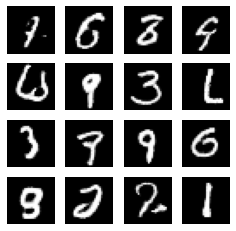

Time for interval 55 is 6.514542579650879 sec
5600 [D loss: 0.318944, r_loss: 0.299508, f_loss: 0.338380, acc.: 91.41%, real_acc:92.97%, fake_acc:89.84%] [G loss: 2.069584]


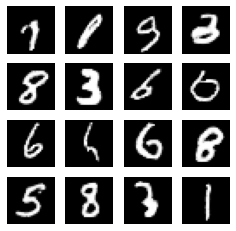

Time for interval 56 is 6.604356288909912 sec
5700 [D loss: 0.372769, r_loss: 0.482476, f_loss: 0.263063, acc.: 87.89%, real_acc:81.25%, fake_acc:94.53%] [G loss: 1.963650]


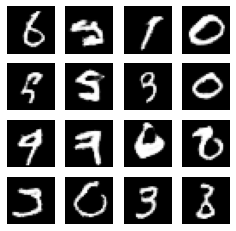

Time for interval 57 is 6.510720252990723 sec
5800 [D loss: 0.401106, r_loss: 0.413385, f_loss: 0.388828, acc.: 87.50%, real_acc:85.94%, fake_acc:89.06%] [G loss: 1.677672]


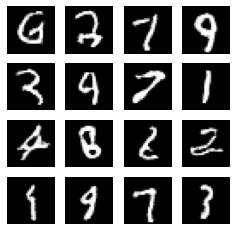

Time for interval 58 is 6.477254152297974 sec
5900 [D loss: 0.298242, r_loss: 0.297430, f_loss: 0.299054, acc.: 92.58%, real_acc:92.19%, fake_acc:92.97%] [G loss: 1.896658]


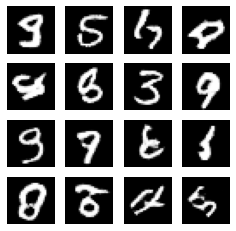

Time for interval 59 is 6.633723020553589 sec
6000 [D loss: 0.405722, r_loss: 0.438385, f_loss: 0.373059, acc.: 84.77%, real_acc:80.47%, fake_acc:89.06%] [G loss: 2.164554]


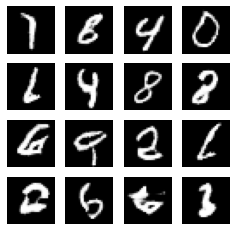

Time for interval 60 is 6.511800289154053 sec
6100 [D loss: 0.399171, r_loss: 0.430827, f_loss: 0.367516, acc.: 85.16%, real_acc:83.59%, fake_acc:86.72%] [G loss: 1.982271]


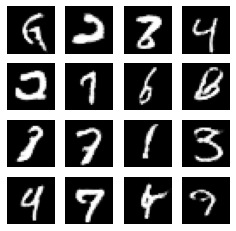

Time for interval 61 is 6.533064842224121 sec
6200 [D loss: 0.439620, r_loss: 0.496511, f_loss: 0.382729, acc.: 84.38%, real_acc:80.47%, fake_acc:88.28%] [G loss: 2.231781]


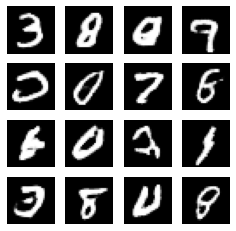

Time for interval 62 is 6.5155651569366455 sec
6300 [D loss: 0.388505, r_loss: 0.342212, f_loss: 0.434798, acc.: 86.72%, real_acc:89.06%, fake_acc:84.38%] [G loss: 2.092936]


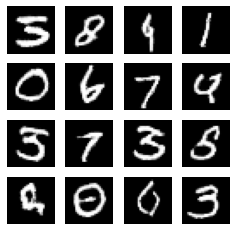

Time for interval 63 is 6.604429244995117 sec
6400 [D loss: 0.347879, r_loss: 0.362152, f_loss: 0.333607, acc.: 89.06%, real_acc:89.06%, fake_acc:89.06%] [G loss: 1.779279]


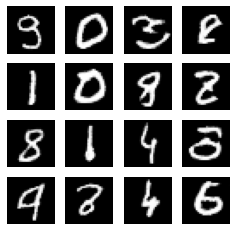

Time for interval 64 is 6.520976543426514 sec
6500 [D loss: 0.488829, r_loss: 0.437119, f_loss: 0.540540, acc.: 78.12%, real_acc:83.59%, fake_acc:72.66%] [G loss: 1.899359]


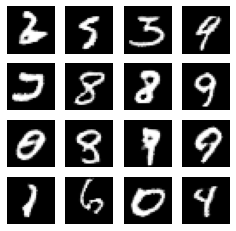

Time for interval 65 is 6.50300669670105 sec
6600 [D loss: 0.340746, r_loss: 0.314246, f_loss: 0.367246, acc.: 91.41%, real_acc:96.88%, fake_acc:85.94%] [G loss: 1.911785]


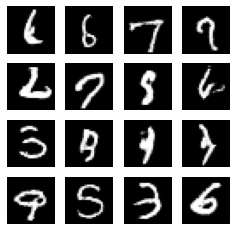

Time for interval 66 is 6.607154607772827 sec
6700 [D loss: 0.317576, r_loss: 0.303713, f_loss: 0.331439, acc.: 91.02%, real_acc:94.53%, fake_acc:87.50%] [G loss: 1.995573]


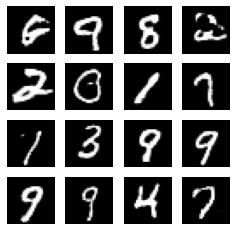

Time for interval 67 is 6.491018772125244 sec
6800 [D loss: 0.340451, r_loss: 0.351094, f_loss: 0.329809, acc.: 90.23%, real_acc:88.28%, fake_acc:92.19%] [G loss: 1.971602]


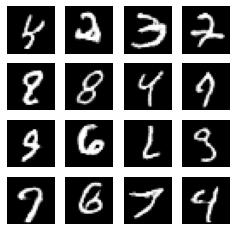

Time for interval 68 is 6.53048038482666 sec
6900 [D loss: 0.328320, r_loss: 0.391819, f_loss: 0.264822, acc.: 89.84%, real_acc:85.94%, fake_acc:93.75%] [G loss: 2.212338]


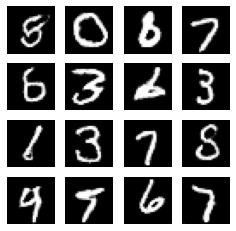

Time for interval 69 is 6.5479254722595215 sec
7000 [D loss: 0.328029, r_loss: 0.287821, f_loss: 0.368237, acc.: 91.02%, real_acc:92.97%, fake_acc:89.06%] [G loss: 2.250678]


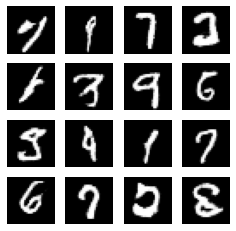

Time for interval 70 is 6.628619432449341 sec
7100 [D loss: 0.373899, r_loss: 0.341420, f_loss: 0.406378, acc.: 87.50%, real_acc:90.62%, fake_acc:84.38%] [G loss: 2.375662]


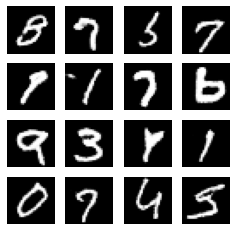

Time for interval 71 is 6.545430421829224 sec
7200 [D loss: 0.316847, r_loss: 0.293358, f_loss: 0.340335, acc.: 90.23%, real_acc:90.62%, fake_acc:89.84%] [G loss: 2.321469]


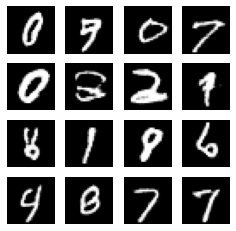

Time for interval 72 is 6.503810167312622 sec
7300 [D loss: 0.367360, r_loss: 0.373379, f_loss: 0.361340, acc.: 87.89%, real_acc:90.62%, fake_acc:85.16%] [G loss: 1.861132]


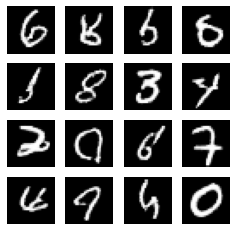

Time for interval 73 is 6.63314151763916 sec
7400 [D loss: 0.315780, r_loss: 0.308366, f_loss: 0.323193, acc.: 91.41%, real_acc:92.97%, fake_acc:89.84%] [G loss: 2.299828]


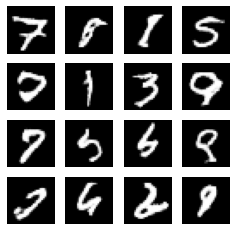

Time for interval 74 is 6.5554187297821045 sec
7500 [D loss: 0.317041, r_loss: 0.312568, f_loss: 0.321513, acc.: 90.23%, real_acc:91.41%, fake_acc:89.06%] [G loss: 2.046752]


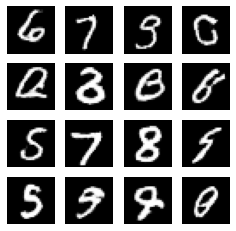

Time for interval 75 is 6.578807592391968 sec
7600 [D loss: 0.306975, r_loss: 0.341044, f_loss: 0.272906, acc.: 91.80%, real_acc:89.84%, fake_acc:93.75%] [G loss: 1.787808]


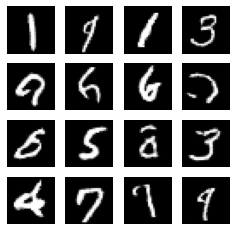

Time for interval 76 is 6.5720086097717285 sec
7700 [D loss: 0.323084, r_loss: 0.248210, f_loss: 0.397958, acc.: 89.06%, real_acc:96.09%, fake_acc:82.03%] [G loss: 1.774273]


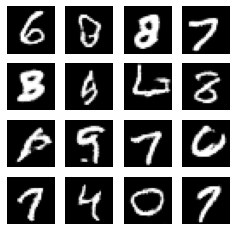

Time for interval 77 is 6.6156392097473145 sec
7800 [D loss: 0.353801, r_loss: 0.250817, f_loss: 0.456784, acc.: 90.62%, real_acc:96.88%, fake_acc:84.38%] [G loss: 2.320895]


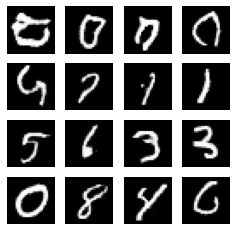

Time for interval 78 is 6.497281551361084 sec
7900 [D loss: 0.204175, r_loss: 0.200012, f_loss: 0.208337, acc.: 97.27%, real_acc:97.66%, fake_acc:96.88%] [G loss: 2.876230]


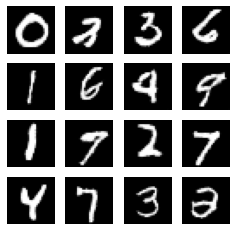

Time for interval 79 is 6.533806085586548 sec
8000 [D loss: 0.275277, r_loss: 0.306982, f_loss: 0.243572, acc.: 93.75%, real_acc:92.97%, fake_acc:94.53%] [G loss: 2.305626]


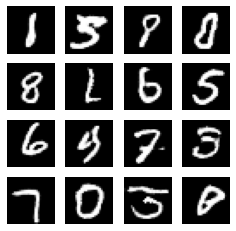

Time for interval 80 is 6.653721332550049 sec
8100 [D loss: 0.247409, r_loss: 0.294326, f_loss: 0.200491, acc.: 94.92%, real_acc:92.19%, fake_acc:97.66%] [G loss: 2.076249]


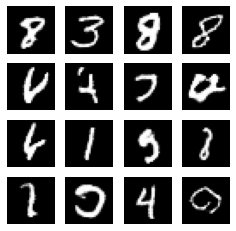

Time for interval 81 is 6.544836044311523 sec
8200 [D loss: 0.389884, r_loss: 0.345258, f_loss: 0.434510, acc.: 85.55%, real_acc:89.84%, fake_acc:81.25%] [G loss: 1.734059]


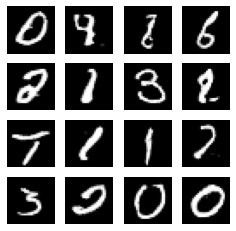

Time for interval 82 is 6.500021696090698 sec
8300 [D loss: 0.437069, r_loss: 0.495416, f_loss: 0.378722, acc.: 79.69%, real_acc:74.22%, fake_acc:85.16%] [G loss: 1.666837]


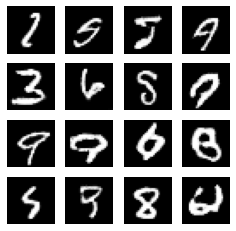

Time for interval 83 is 6.5996010303497314 sec
8400 [D loss: 0.337096, r_loss: 0.329640, f_loss: 0.344552, acc.: 87.89%, real_acc:89.84%, fake_acc:85.94%] [G loss: 2.161294]


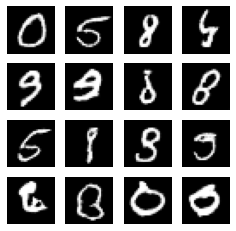

Time for interval 84 is 6.707616806030273 sec
8500 [D loss: 0.325394, r_loss: 0.360226, f_loss: 0.290561, acc.: 90.62%, real_acc:89.06%, fake_acc:92.19%] [G loss: 1.869739]


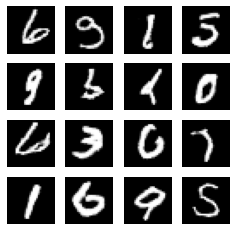

Time for interval 85 is 6.697983264923096 sec
8600 [D loss: 0.350530, r_loss: 0.427535, f_loss: 0.273524, acc.: 89.84%, real_acc:85.16%, fake_acc:94.53%] [G loss: 2.010402]


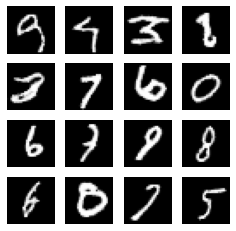

Time for interval 86 is 6.520183801651001 sec
8700 [D loss: 0.328207, r_loss: 0.315172, f_loss: 0.341243, acc.: 92.58%, real_acc:94.53%, fake_acc:90.62%] [G loss: 2.270454]


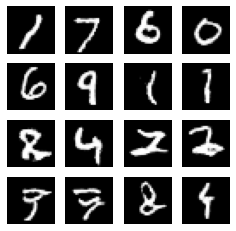

Time for interval 87 is 6.698116302490234 sec
8800 [D loss: 0.271295, r_loss: 0.192190, f_loss: 0.350400, acc.: 91.80%, real_acc:97.66%, fake_acc:85.94%] [G loss: 2.067761]


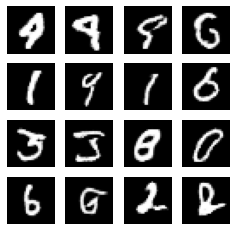

Time for interval 88 is 6.510625839233398 sec
8900 [D loss: 0.299145, r_loss: 0.343640, f_loss: 0.254650, acc.: 90.23%, real_acc:87.50%, fake_acc:92.97%] [G loss: 2.058935]


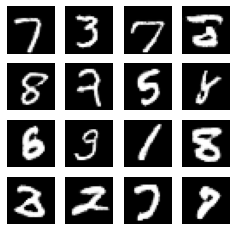

Time for interval 89 is 6.468555450439453 sec
9000 [D loss: 0.319695, r_loss: 0.335037, f_loss: 0.304353, acc.: 91.80%, real_acc:89.84%, fake_acc:93.75%] [G loss: 2.367843]


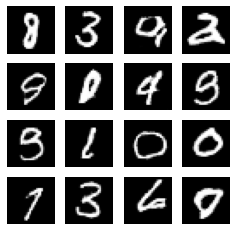

Time for interval 90 is 6.599524021148682 sec
9100 [D loss: 0.257213, r_loss: 0.177576, f_loss: 0.336849, acc.: 94.14%, real_acc:98.44%, fake_acc:89.84%] [G loss: 2.546594]


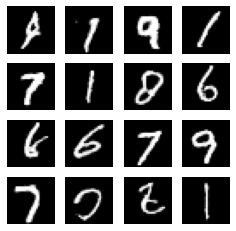

Time for interval 91 is 6.6034181118011475 sec
9200 [D loss: 0.261349, r_loss: 0.294921, f_loss: 0.227777, acc.: 95.31%, real_acc:94.53%, fake_acc:96.09%] [G loss: 2.001016]


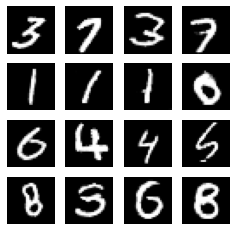

Time for interval 92 is 6.481961727142334 sec
9300 [D loss: 0.422557, r_loss: 0.386617, f_loss: 0.458496, acc.: 82.03%, real_acc:89.06%, fake_acc:75.00%] [G loss: 2.324059]


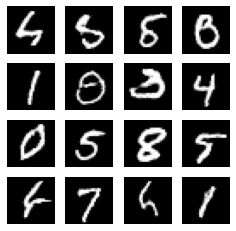

Time for interval 93 is 6.558908700942993 sec
9400 [D loss: 0.248685, r_loss: 0.284515, f_loss: 0.212856, acc.: 94.53%, real_acc:94.53%, fake_acc:94.53%] [G loss: 2.720491]


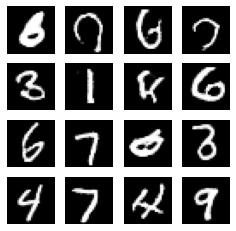

Time for interval 94 is 6.7250001430511475 sec
9500 [D loss: 0.343635, r_loss: 0.268289, f_loss: 0.418982, acc.: 90.62%, real_acc:96.09%, fake_acc:85.16%] [G loss: 2.136025]


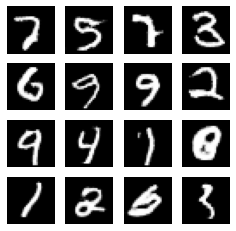

Time for interval 95 is 6.478330373764038 sec
9600 [D loss: 0.371652, r_loss: 0.409318, f_loss: 0.333985, acc.: 87.50%, real_acc:83.59%, fake_acc:91.41%] [G loss: 1.962773]


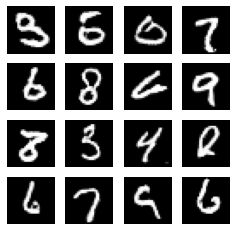

Time for interval 96 is 6.49471116065979 sec
9700 [D loss: 0.374168, r_loss: 0.418171, f_loss: 0.330164, acc.: 87.89%, real_acc:85.16%, fake_acc:90.62%] [G loss: 2.120529]


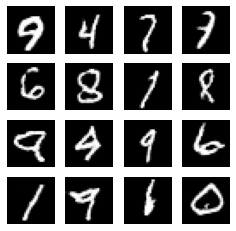

Time for interval 97 is 6.582427978515625 sec
9800 [D loss: 0.259071, r_loss: 0.258971, f_loss: 0.259171, acc.: 93.36%, real_acc:93.75%, fake_acc:92.97%] [G loss: 2.291452]


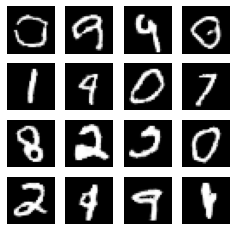

Time for interval 98 is 6.636898040771484 sec
9900 [D loss: 0.288249, r_loss: 0.234412, f_loss: 0.342086, acc.: 93.75%, real_acc:96.09%, fake_acc:91.41%] [G loss: 2.238928]


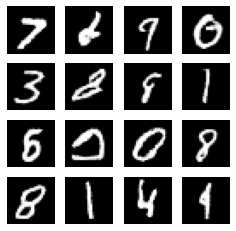

Time for interval 99 is 6.699477910995483 sec
10000 [D loss: 0.259816, r_loss: 0.347828, f_loss: 0.171804, acc.: 91.41%, real_acc:85.16%, fake_acc:97.66%] [G loss: 2.034972]


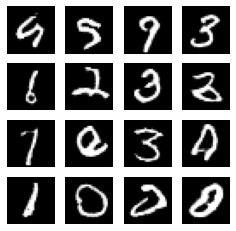

Time for interval 100 is 6.602996826171875 sec
10100 [D loss: 0.336426, r_loss: 0.396558, f_loss: 0.276294, acc.: 90.62%, real_acc:87.50%, fake_acc:93.75%] [G loss: 2.071785]


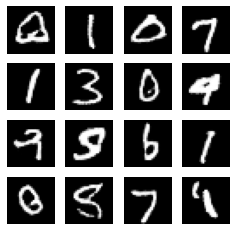

Time for interval 101 is 6.617701292037964 sec
10200 [D loss: 0.495565, r_loss: 0.524977, f_loss: 0.466153, acc.: 78.12%, real_acc:75.00%, fake_acc:81.25%] [G loss: 2.135971]


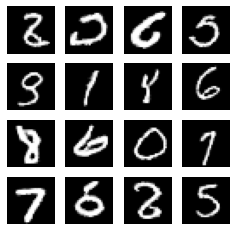

Time for interval 102 is 6.528900623321533 sec
10300 [D loss: 0.357674, r_loss: 0.339809, f_loss: 0.375538, acc.: 87.50%, real_acc:91.41%, fake_acc:83.59%] [G loss: 1.950240]


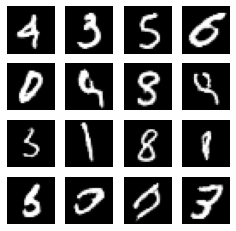

Time for interval 103 is 6.552797079086304 sec
10400 [D loss: 0.204612, r_loss: 0.176151, f_loss: 0.233072, acc.: 98.83%, real_acc:100.00%, fake_acc:97.66%] [G loss: 2.401030]


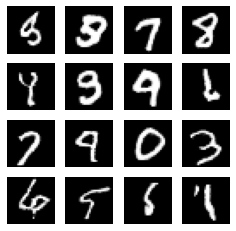

Time for interval 104 is 6.510439395904541 sec
10500 [D loss: 0.317057, r_loss: 0.279693, f_loss: 0.354422, acc.: 87.89%, real_acc:89.84%, fake_acc:85.94%] [G loss: 2.746851]


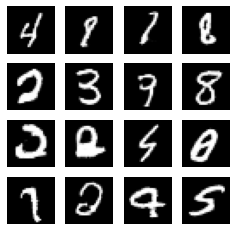

Time for interval 105 is 6.654076099395752 sec
10600 [D loss: 0.299254, r_loss: 0.228753, f_loss: 0.369756, acc.: 89.84%, real_acc:96.88%, fake_acc:82.81%] [G loss: 2.575905]


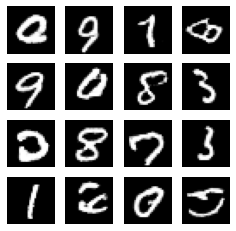

Time for interval 106 is 6.510662317276001 sec
10700 [D loss: 0.332521, r_loss: 0.330195, f_loss: 0.334846, acc.: 87.89%, real_acc:87.50%, fake_acc:88.28%] [G loss: 1.821087]


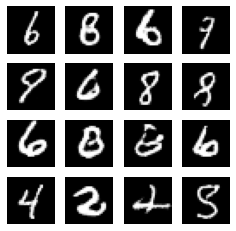

Time for interval 107 is 6.452430248260498 sec
10800 [D loss: 0.278009, r_loss: 0.293972, f_loss: 0.262046, acc.: 91.80%, real_acc:91.41%, fake_acc:92.19%] [G loss: 1.837323]


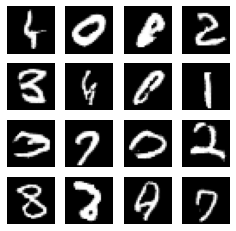

Time for interval 108 is 6.636479139328003 sec
10900 [D loss: 0.328201, r_loss: 0.302028, f_loss: 0.354374, acc.: 89.06%, real_acc:91.41%, fake_acc:86.72%] [G loss: 2.498284]


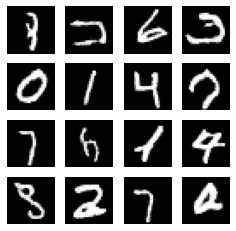

Time for interval 109 is 6.534693241119385 sec
11000 [D loss: 0.233037, r_loss: 0.262717, f_loss: 0.203358, acc.: 95.70%, real_acc:95.31%, fake_acc:96.09%] [G loss: 2.194000]


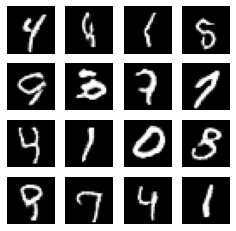

Time for interval 110 is 6.58415150642395 sec
11100 [D loss: 0.367108, r_loss: 0.363335, f_loss: 0.370880, acc.: 84.77%, real_acc:83.59%, fake_acc:85.94%] [G loss: 2.289431]


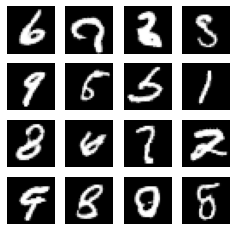

Time for interval 111 is 6.484500885009766 sec
11200 [D loss: 0.258167, r_loss: 0.209355, f_loss: 0.306979, acc.: 94.14%, real_acc:97.66%, fake_acc:90.62%] [G loss: 2.710560]


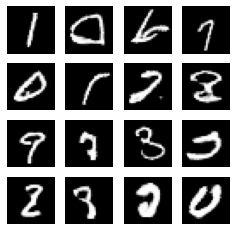

Time for interval 112 is 7.060031414031982 sec
11300 [D loss: 0.210307, r_loss: 0.195158, f_loss: 0.225456, acc.: 96.48%, real_acc:97.66%, fake_acc:95.31%] [G loss: 2.191742]


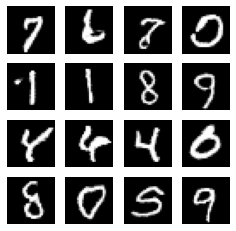

Time for interval 113 is 6.460025072097778 sec
11400 [D loss: 0.216792, r_loss: 0.245259, f_loss: 0.188325, acc.: 97.27%, real_acc:96.88%, fake_acc:97.66%] [G loss: 2.384227]


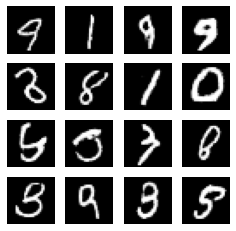

Time for interval 114 is 6.7022621631622314 sec
11500 [D loss: 0.362384, r_loss: 0.321588, f_loss: 0.403179, acc.: 85.94%, real_acc:92.19%, fake_acc:79.69%] [G loss: 1.993252]


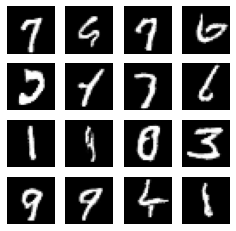

Time for interval 115 is 6.778751373291016 sec
11600 [D loss: 0.233001, r_loss: 0.177196, f_loss: 0.288806, acc.: 94.92%, real_acc:97.66%, fake_acc:92.19%] [G loss: 2.384339]


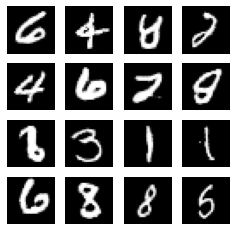

Time for interval 116 is 7.000824689865112 sec
11700 [D loss: 0.272353, r_loss: 0.273864, f_loss: 0.270842, acc.: 95.31%, real_acc:93.75%, fake_acc:96.88%] [G loss: 2.621743]


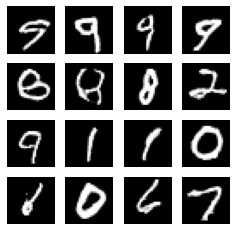

Time for interval 117 is 6.982101202011108 sec
11800 [D loss: 0.198126, r_loss: 0.175472, f_loss: 0.220781, acc.: 96.48%, real_acc:96.88%, fake_acc:96.09%] [G loss: 2.249549]


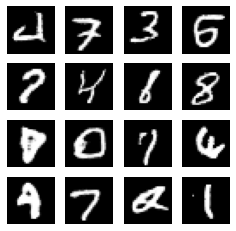

Time for interval 118 is 6.754042148590088 sec
11900 [D loss: 0.245240, r_loss: 0.236895, f_loss: 0.253585, acc.: 95.31%, real_acc:98.44%, fake_acc:92.19%] [G loss: 2.675217]


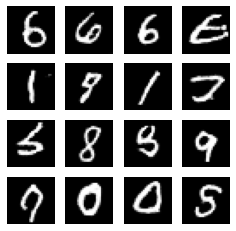

Time for interval 119 is 6.587549686431885 sec
12000 [D loss: 0.331063, r_loss: 0.407787, f_loss: 0.254340, acc.: 89.45%, real_acc:85.16%, fake_acc:93.75%] [G loss: 1.980273]


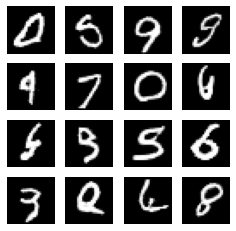

Time for interval 120 is 6.512469291687012 sec
12100 [D loss: 0.203490, r_loss: 0.182231, f_loss: 0.224749, acc.: 96.09%, real_acc:96.88%, fake_acc:95.31%] [G loss: 2.523261]


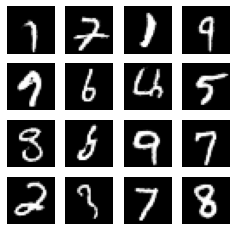

Time for interval 121 is 6.475917816162109 sec
12200 [D loss: 0.221437, r_loss: 0.197685, f_loss: 0.245189, acc.: 96.48%, real_acc:98.44%, fake_acc:94.53%] [G loss: 2.440964]


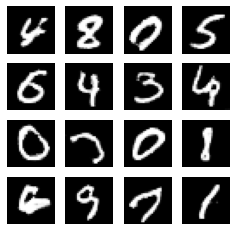

Time for interval 122 is 6.5759499073028564 sec
12300 [D loss: 0.314514, r_loss: 0.240467, f_loss: 0.388561, acc.: 91.02%, real_acc:97.66%, fake_acc:84.38%] [G loss: 3.100357]


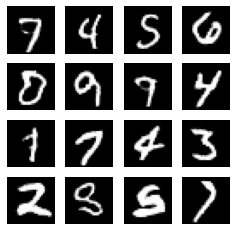

Time for interval 123 is 6.527633190155029 sec
12400 [D loss: 0.211989, r_loss: 0.268784, f_loss: 0.155193, acc.: 95.70%, real_acc:93.75%, fake_acc:97.66%] [G loss: 2.530034]


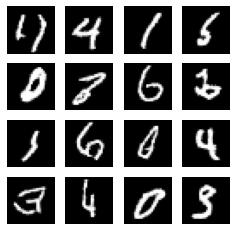

Time for interval 124 is 6.479944467544556 sec
12500 [D loss: 0.281515, r_loss: 0.312189, f_loss: 0.250841, acc.: 90.23%, real_acc:88.28%, fake_acc:92.19%] [G loss: 2.152072]


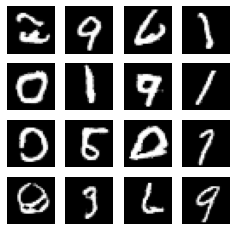

Time for interval 125 is 6.45876669883728 sec
12600 [D loss: 0.142244, r_loss: 0.177298, f_loss: 0.107190, acc.: 98.44%, real_acc:97.66%, fake_acc:99.22%] [G loss: 2.252952]


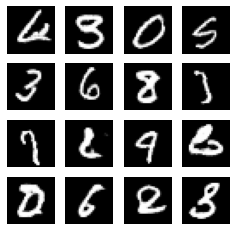

Time for interval 126 is 6.594522476196289 sec
12700 [D loss: 0.245784, r_loss: 0.228435, f_loss: 0.263133, acc.: 94.92%, real_acc:96.09%, fake_acc:93.75%] [G loss: 2.822798]


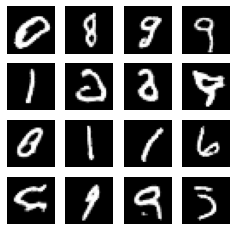

Time for interval 127 is 6.455899000167847 sec
12800 [D loss: 0.199885, r_loss: 0.223159, f_loss: 0.176611, acc.: 97.27%, real_acc:95.31%, fake_acc:99.22%] [G loss: 2.420729]


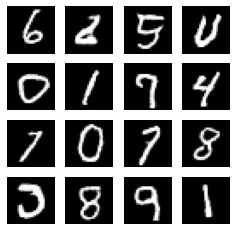

Time for interval 128 is 6.489558696746826 sec
12900 [D loss: 0.276959, r_loss: 0.361518, f_loss: 0.192399, acc.: 94.14%, real_acc:89.84%, fake_acc:98.44%] [G loss: 2.595152]


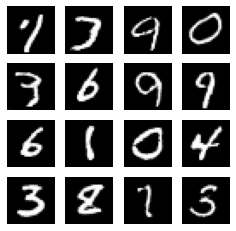

Time for interval 129 is 6.635650873184204 sec
13000 [D loss: 0.360918, r_loss: 0.336191, f_loss: 0.385645, acc.: 88.28%, real_acc:86.72%, fake_acc:89.84%] [G loss: 2.136153]


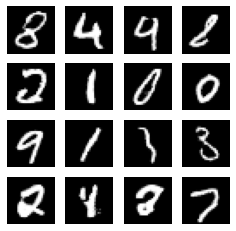

Time for interval 130 is 6.691293478012085 sec
13100 [D loss: 0.270011, r_loss: 0.271667, f_loss: 0.268355, acc.: 93.75%, real_acc:94.53%, fake_acc:92.97%] [G loss: 3.250296]


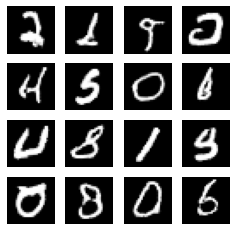

Time for interval 131 is 6.679139614105225 sec
13200 [D loss: 0.253781, r_loss: 0.230981, f_loss: 0.276580, acc.: 95.31%, real_acc:96.88%, fake_acc:93.75%] [G loss: 2.460601]


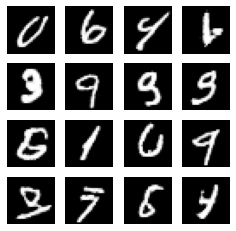

Time for interval 132 is 6.607149600982666 sec
13300 [D loss: 0.279515, r_loss: 0.237084, f_loss: 0.321947, acc.: 92.97%, real_acc:94.53%, fake_acc:91.41%] [G loss: 2.498693]


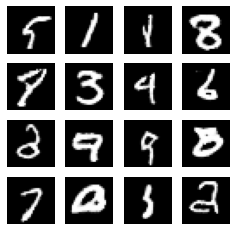

Time for interval 133 is 6.592613697052002 sec
13400 [D loss: 0.246766, r_loss: 0.221064, f_loss: 0.272468, acc.: 93.36%, real_acc:94.53%, fake_acc:92.19%] [G loss: 2.573216]


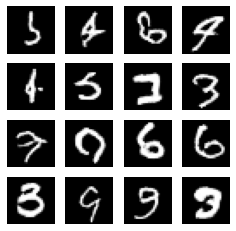

Time for interval 134 is 6.439085483551025 sec
13500 [D loss: 0.171818, r_loss: 0.178812, f_loss: 0.164823, acc.: 98.83%, real_acc:99.22%, fake_acc:98.44%] [G loss: 2.483425]


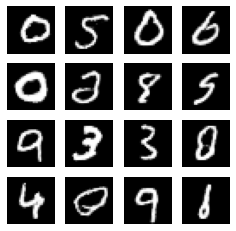

Time for interval 135 is 6.45924186706543 sec
13600 [D loss: 0.258468, r_loss: 0.321713, f_loss: 0.195223, acc.: 91.80%, real_acc:87.50%, fake_acc:96.09%] [G loss: 2.457495]


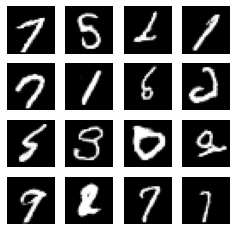

Time for interval 136 is 6.561837196350098 sec
13700 [D loss: 0.236817, r_loss: 0.221379, f_loss: 0.252255, acc.: 94.14%, real_acc:94.53%, fake_acc:93.75%] [G loss: 2.731071]


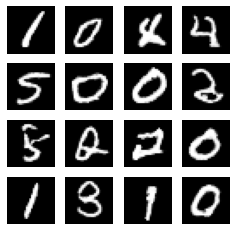

Time for interval 137 is 6.502023220062256 sec
13800 [D loss: 0.303660, r_loss: 0.359018, f_loss: 0.248302, acc.: 89.84%, real_acc:85.16%, fake_acc:94.53%] [G loss: 2.759630]


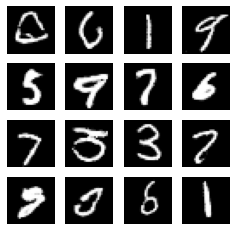

Time for interval 138 is 6.463165760040283 sec
13900 [D loss: 0.286641, r_loss: 0.296991, f_loss: 0.276291, acc.: 92.19%, real_acc:92.19%, fake_acc:92.19%] [G loss: 2.532777]


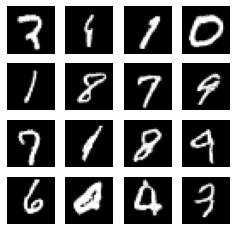

Time for interval 139 is 6.474639654159546 sec
14000 [D loss: 0.299269, r_loss: 0.305496, f_loss: 0.293042, acc.: 92.19%, real_acc:92.19%, fake_acc:92.19%] [G loss: 2.901360]


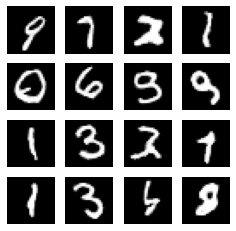

Time for interval 140 is 6.589136838912964 sec
14100 [D loss: 0.339072, r_loss: 0.255411, f_loss: 0.422733, acc.: 88.28%, real_acc:93.75%, fake_acc:82.81%] [G loss: 3.058081]


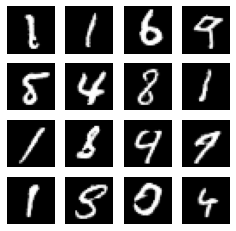

Time for interval 141 is 6.453420639038086 sec
14200 [D loss: 0.198083, r_loss: 0.152895, f_loss: 0.243271, acc.: 97.27%, real_acc:99.22%, fake_acc:95.31%] [G loss: 3.126177]


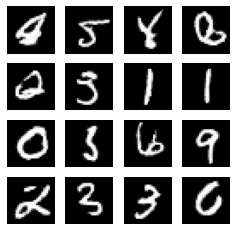

Time for interval 142 is 6.552089691162109 sec
14300 [D loss: 0.251403, r_loss: 0.317584, f_loss: 0.185222, acc.: 93.36%, real_acc:88.28%, fake_acc:98.44%] [G loss: 2.678009]


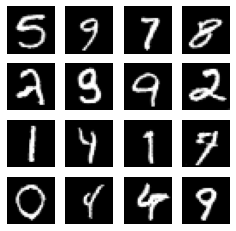

Time for interval 143 is 6.626230478286743 sec
14400 [D loss: 0.232422, r_loss: 0.249250, f_loss: 0.215593, acc.: 96.48%, real_acc:96.88%, fake_acc:96.09%] [G loss: 2.352965]


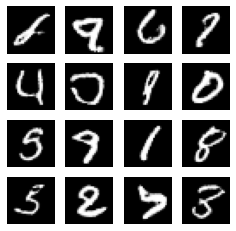

Time for interval 144 is 6.441441535949707 sec
14500 [D loss: 0.344819, r_loss: 0.324814, f_loss: 0.364823, acc.: 88.67%, real_acc:89.06%, fake_acc:88.28%] [G loss: 2.797737]


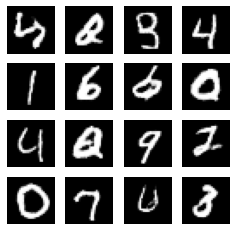

Time for interval 145 is 6.424913644790649 sec
14600 [D loss: 0.318284, r_loss: 0.317588, f_loss: 0.318980, acc.: 88.67%, real_acc:90.62%, fake_acc:86.72%] [G loss: 2.196707]


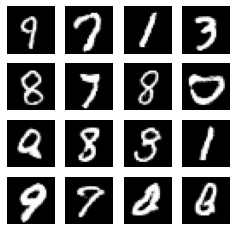

Time for interval 146 is 6.492510080337524 sec
14700 [D loss: 0.341659, r_loss: 0.343081, f_loss: 0.340236, acc.: 86.33%, real_acc:85.94%, fake_acc:86.72%] [G loss: 2.132561]


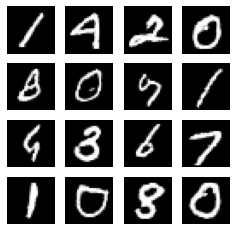

Time for interval 147 is 6.59317421913147 sec
14800 [D loss: 0.420546, r_loss: 0.638604, f_loss: 0.202488, acc.: 80.47%, real_acc:64.84%, fake_acc:96.09%] [G loss: 1.957161]


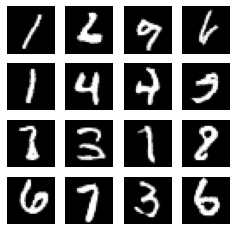

Time for interval 148 is 6.482808351516724 sec
14900 [D loss: 0.285070, r_loss: 0.335786, f_loss: 0.234355, acc.: 92.19%, real_acc:89.84%, fake_acc:94.53%] [G loss: 2.715866]


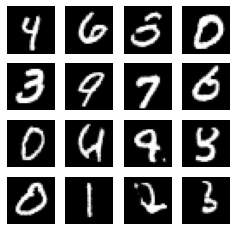

Time for interval 149 is 6.5099406242370605 sec
15000 [D loss: 0.209262, r_loss: 0.234680, f_loss: 0.183844, acc.: 95.70%, real_acc:94.53%, fake_acc:96.88%] [G loss: 2.778749]


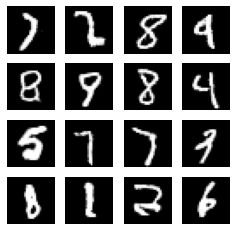

Time for interval 150 is 6.599480867385864 sec
15100 [D loss: 0.347960, r_loss: 0.331191, f_loss: 0.364729, acc.: 87.50%, real_acc:89.84%, fake_acc:85.16%] [G loss: 2.118471]


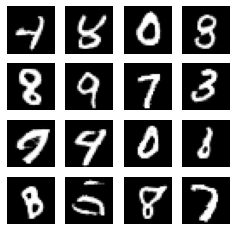

Time for interval 151 is 6.513833045959473 sec
15200 [D loss: 0.215700, r_loss: 0.223526, f_loss: 0.207874, acc.: 93.75%, real_acc:95.31%, fake_acc:92.19%] [G loss: 3.035503]


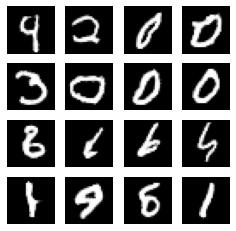

Time for interval 152 is 6.527485132217407 sec
15300 [D loss: 0.199097, r_loss: 0.276212, f_loss: 0.121981, acc.: 96.09%, real_acc:92.97%, fake_acc:99.22%] [G loss: 3.447001]


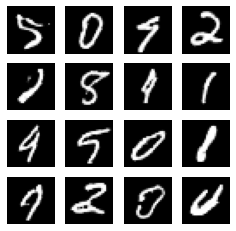

Time for interval 153 is 6.740184307098389 sec
15400 [D loss: 0.306907, r_loss: 0.308465, f_loss: 0.305349, acc.: 91.41%, real_acc:92.97%, fake_acc:89.84%] [G loss: 2.893661]


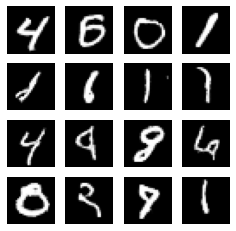

Time for interval 154 is 6.809350252151489 sec
15500 [D loss: 0.279512, r_loss: 0.299042, f_loss: 0.259982, acc.: 93.75%, real_acc:93.75%, fake_acc:93.75%] [G loss: 2.605984]


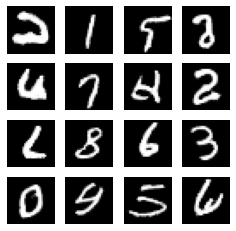

Time for interval 155 is 6.6811909675598145 sec
15600 [D loss: 0.301251, r_loss: 0.283625, f_loss: 0.318877, acc.: 91.02%, real_acc:92.97%, fake_acc:89.06%] [G loss: 2.346807]


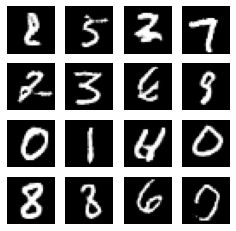

Time for interval 156 is 6.585510969161987 sec
15700 [D loss: 0.235859, r_loss: 0.197951, f_loss: 0.273767, acc.: 93.75%, real_acc:94.53%, fake_acc:92.97%] [G loss: 2.709541]


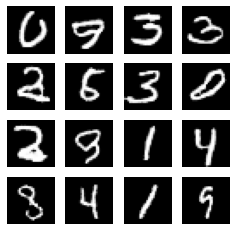

Time for interval 157 is 6.567481994628906 sec
15800 [D loss: 0.273393, r_loss: 0.250795, f_loss: 0.295991, acc.: 94.14%, real_acc:96.09%, fake_acc:92.19%] [G loss: 2.897460]


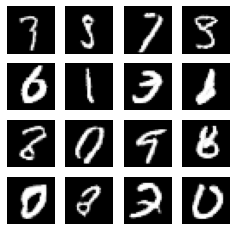

Time for interval 158 is 6.467855453491211 sec
15900 [D loss: 0.226308, r_loss: 0.186283, f_loss: 0.266333, acc.: 92.97%, real_acc:96.88%, fake_acc:89.06%] [G loss: 2.536417]


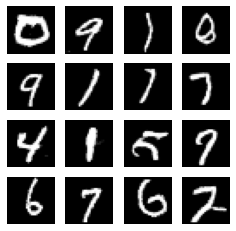

Time for interval 159 is 6.469356536865234 sec
16000 [D loss: 0.309879, r_loss: 0.392566, f_loss: 0.227192, acc.: 89.84%, real_acc:84.38%, fake_acc:95.31%] [G loss: 2.664543]


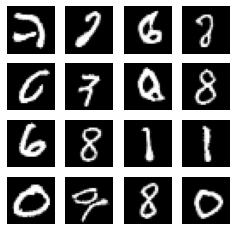

Time for interval 160 is 6.499905109405518 sec
16100 [D loss: 0.207189, r_loss: 0.251228, f_loss: 0.163151, acc.: 95.31%, real_acc:92.97%, fake_acc:97.66%] [G loss: 2.798312]


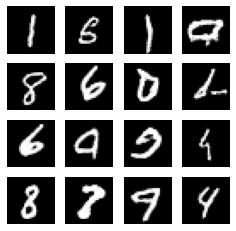

Time for interval 161 is 6.596843719482422 sec
16200 [D loss: 0.339549, r_loss: 0.344074, f_loss: 0.335025, acc.: 88.67%, real_acc:87.50%, fake_acc:89.84%] [G loss: 2.466717]


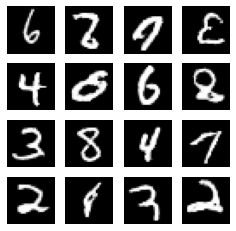

Time for interval 162 is 6.475554466247559 sec
16300 [D loss: 0.285820, r_loss: 0.197081, f_loss: 0.374559, acc.: 91.41%, real_acc:99.22%, fake_acc:83.59%] [G loss: 3.307155]


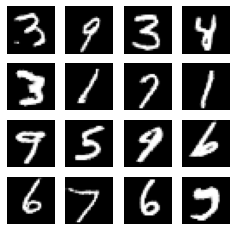

Time for interval 163 is 6.514355182647705 sec
16400 [D loss: 0.201751, r_loss: 0.261304, f_loss: 0.142198, acc.: 98.05%, real_acc:96.09%, fake_acc:100.00%] [G loss: 2.152932]


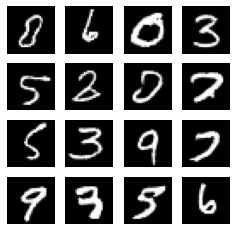

Time for interval 164 is 6.653887510299683 sec
16500 [D loss: 0.196880, r_loss: 0.195212, f_loss: 0.198547, acc.: 96.09%, real_acc:96.88%, fake_acc:95.31%] [G loss: 2.508728]


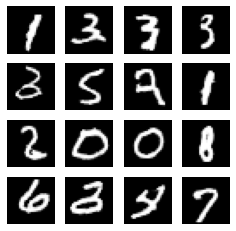

Time for interval 165 is 6.506672382354736 sec
16600 [D loss: 0.236770, r_loss: 0.289161, f_loss: 0.184380, acc.: 94.53%, real_acc:91.41%, fake_acc:97.66%] [G loss: 2.670483]


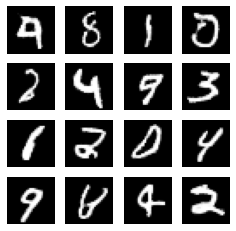

Time for interval 166 is 6.56724214553833 sec
16700 [D loss: 0.244719, r_loss: 0.223483, f_loss: 0.265954, acc.: 94.92%, real_acc:96.88%, fake_acc:92.97%] [G loss: 2.392890]


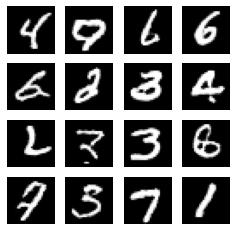

Time for interval 167 is 6.880098104476929 sec
16800 [D loss: 0.171220, r_loss: 0.170024, f_loss: 0.172415, acc.: 97.27%, real_acc:96.88%, fake_acc:97.66%] [G loss: 3.071784]


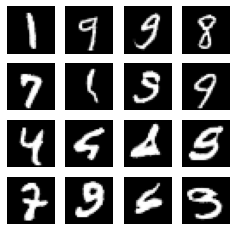

Time for interval 168 is 6.698628664016724 sec
16900 [D loss: 0.310931, r_loss: 0.152354, f_loss: 0.469507, acc.: 87.89%, real_acc:98.44%, fake_acc:77.34%] [G loss: 2.817949]


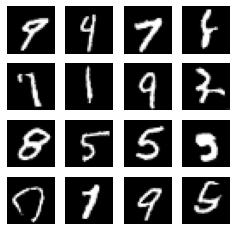

Time for interval 169 is 6.488476514816284 sec
17000 [D loss: 0.166655, r_loss: 0.194517, f_loss: 0.138794, acc.: 98.83%, real_acc:97.66%, fake_acc:100.00%] [G loss: 2.592160]


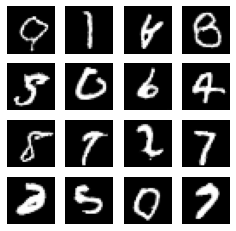

Time for interval 170 is 6.517167568206787 sec
17100 [D loss: 0.272565, r_loss: 0.193566, f_loss: 0.351564, acc.: 91.02%, real_acc:95.31%, fake_acc:86.72%] [G loss: 4.081912]


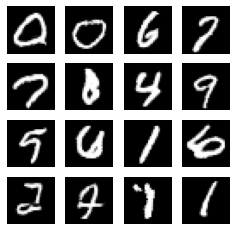

Time for interval 171 is 6.594598293304443 sec
17200 [D loss: 0.207011, r_loss: 0.260660, f_loss: 0.153362, acc.: 97.27%, real_acc:96.09%, fake_acc:98.44%] [G loss: 2.476463]


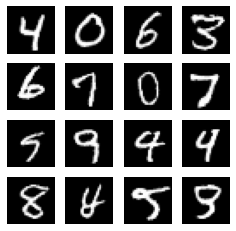

Time for interval 172 is 6.521795988082886 sec
17300 [D loss: 0.249538, r_loss: 0.245070, f_loss: 0.254005, acc.: 94.92%, real_acc:96.09%, fake_acc:93.75%] [G loss: 3.943133]


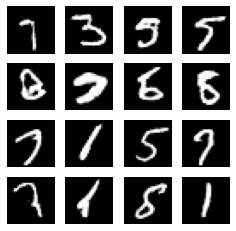

Time for interval 173 is 6.522436141967773 sec
17400 [D loss: 0.247846, r_loss: 0.202301, f_loss: 0.293390, acc.: 92.19%, real_acc:96.88%, fake_acc:87.50%] [G loss: 2.628983]


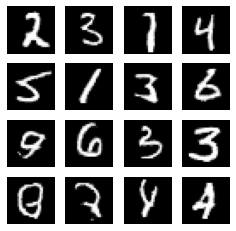

Time for interval 174 is 6.871842622756958 sec
17500 [D loss: 0.286002, r_loss: 0.276271, f_loss: 0.295732, acc.: 91.41%, real_acc:93.75%, fake_acc:89.06%] [G loss: 3.336091]


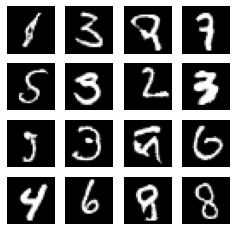

Time for interval 175 is 6.595779895782471 sec
17600 [D loss: 0.258548, r_loss: 0.216736, f_loss: 0.300359, acc.: 94.53%, real_acc:95.31%, fake_acc:93.75%] [G loss: 2.933206]


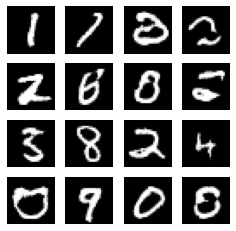

Time for interval 176 is 6.485183954238892 sec
17700 [D loss: 0.158013, r_loss: 0.130568, f_loss: 0.185457, acc.: 98.05%, real_acc:99.22%, fake_acc:96.88%] [G loss: 2.415695]


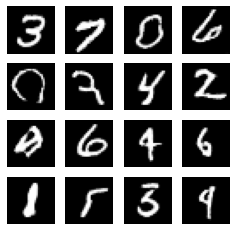

Time for interval 177 is 6.5491557121276855 sec
17800 [D loss: 0.272116, r_loss: 0.359852, f_loss: 0.184379, acc.: 90.62%, real_acc:85.16%, fake_acc:96.09%] [G loss: 3.833977]


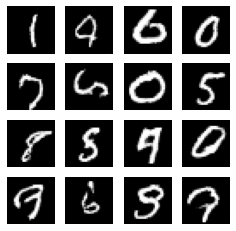

Time for interval 178 is 6.911617755889893 sec
17900 [D loss: 0.176953, r_loss: 0.148656, f_loss: 0.205250, acc.: 97.27%, real_acc:100.00%, fake_acc:94.53%] [G loss: 3.668178]


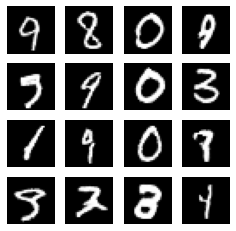

Time for interval 179 is 6.575315475463867 sec
18000 [D loss: 0.202742, r_loss: 0.245113, f_loss: 0.160371, acc.: 94.53%, real_acc:92.97%, fake_acc:96.09%] [G loss: 2.793418]


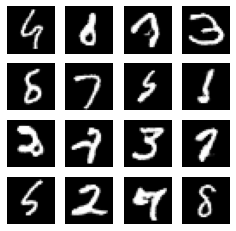

Time for interval 180 is 6.536495923995972 sec
18100 [D loss: 0.264944, r_loss: 0.234206, f_loss: 0.295681, acc.: 91.80%, real_acc:94.53%, fake_acc:89.06%] [G loss: 3.401577]


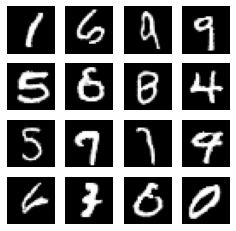

Time for interval 181 is 6.502812147140503 sec
18200 [D loss: 0.204717, r_loss: 0.179472, f_loss: 0.229962, acc.: 96.48%, real_acc:96.88%, fake_acc:96.09%] [G loss: 3.398967]


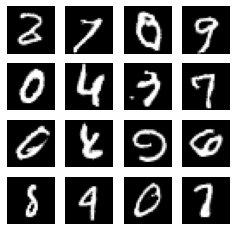

Time for interval 182 is 6.596417188644409 sec
18300 [D loss: 0.269903, r_loss: 0.336779, f_loss: 0.203026, acc.: 92.19%, real_acc:87.50%, fake_acc:96.88%] [G loss: 2.585758]


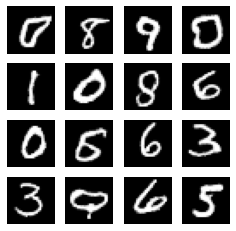

Time for interval 183 is 6.530144929885864 sec
18400 [D loss: 0.398751, r_loss: 0.557265, f_loss: 0.240236, acc.: 82.03%, real_acc:68.75%, fake_acc:95.31%] [G loss: 2.650976]


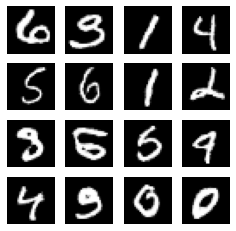

Time for interval 184 is 6.500981330871582 sec
18500 [D loss: 0.155122, r_loss: 0.169957, f_loss: 0.140287, acc.: 97.27%, real_acc:97.66%, fake_acc:96.88%] [G loss: 2.923513]


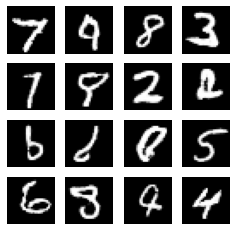

Time for interval 185 is 6.803905725479126 sec
18600 [D loss: 0.134400, r_loss: 0.182270, f_loss: 0.086529, acc.: 97.27%, real_acc:95.31%, fake_acc:99.22%] [G loss: 2.984444]


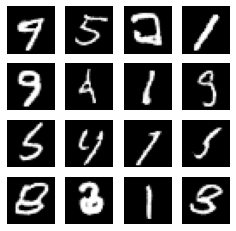

Time for interval 186 is 6.7772276401519775 sec
18700 [D loss: 0.233080, r_loss: 0.319033, f_loss: 0.147126, acc.: 94.14%, real_acc:90.62%, fake_acc:97.66%] [G loss: 2.093185]


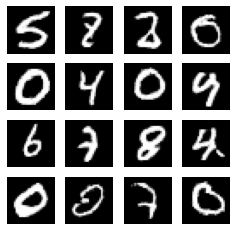

Time for interval 187 is 6.581937313079834 sec
18800 [D loss: 0.245496, r_loss: 0.305977, f_loss: 0.185015, acc.: 93.36%, real_acc:88.28%, fake_acc:98.44%] [G loss: 2.849433]


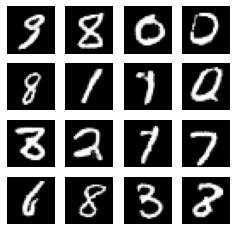

Time for interval 188 is 6.584796667098999 sec
18900 [D loss: 0.210073, r_loss: 0.298309, f_loss: 0.121837, acc.: 94.92%, real_acc:90.62%, fake_acc:99.22%] [G loss: 2.730554]


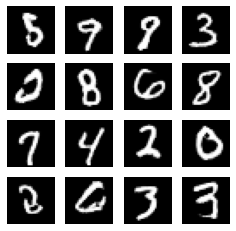

Time for interval 189 is 6.652309417724609 sec
19000 [D loss: 0.230729, r_loss: 0.241097, f_loss: 0.220362, acc.: 95.70%, real_acc:95.31%, fake_acc:96.09%] [G loss: 2.934433]


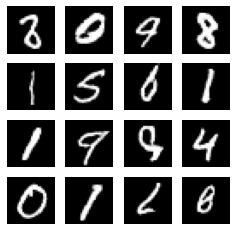

Time for interval 190 is 6.518776893615723 sec
19100 [D loss: 0.244024, r_loss: 0.107961, f_loss: 0.380086, acc.: 92.19%, real_acc:99.22%, fake_acc:85.16%] [G loss: 3.375280]


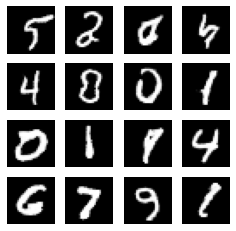

Time for interval 191 is 6.618185043334961 sec
19200 [D loss: 0.275574, r_loss: 0.276246, f_loss: 0.274903, acc.: 94.53%, real_acc:96.88%, fake_acc:92.19%] [G loss: 2.740584]


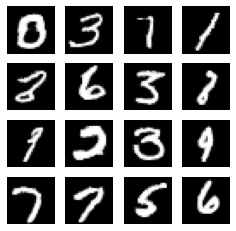

Time for interval 192 is 6.65853476524353 sec
19300 [D loss: 0.136081, r_loss: 0.127524, f_loss: 0.144638, acc.: 98.83%, real_acc:99.22%, fake_acc:98.44%] [G loss: 3.020571]


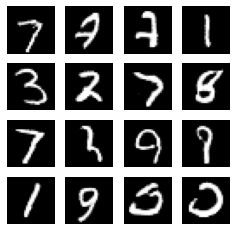

Time for interval 193 is 6.563646554946899 sec
19400 [D loss: 0.133812, r_loss: 0.111462, f_loss: 0.156162, acc.: 98.44%, real_acc:97.66%, fake_acc:99.22%] [G loss: 3.327026]


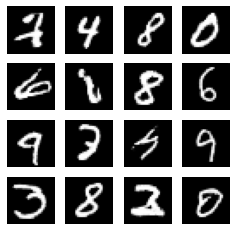

Time for interval 194 is 6.730855703353882 sec
19500 [D loss: 0.194305, r_loss: 0.157208, f_loss: 0.231402, acc.: 94.53%, real_acc:97.66%, fake_acc:91.41%] [G loss: 3.577727]


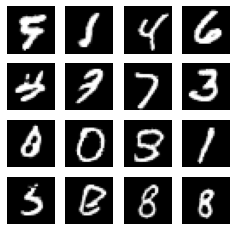

Time for interval 195 is 6.702985763549805 sec
19600 [D loss: 0.260612, r_loss: 0.329703, f_loss: 0.191522, acc.: 95.70%, real_acc:92.97%, fake_acc:98.44%] [G loss: 2.726641]


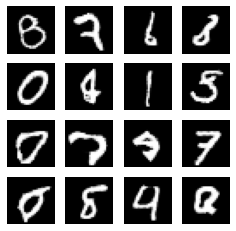

Time for interval 196 is 6.620941400527954 sec
19700 [D loss: 0.252135, r_loss: 0.202140, f_loss: 0.302130, acc.: 92.97%, real_acc:98.44%, fake_acc:87.50%] [G loss: 2.695036]


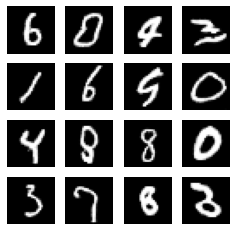

Time for interval 197 is 6.541873216629028 sec
19800 [D loss: 0.289421, r_loss: 0.408749, f_loss: 0.170094, acc.: 89.06%, real_acc:81.25%, fake_acc:96.88%] [G loss: 3.119754]


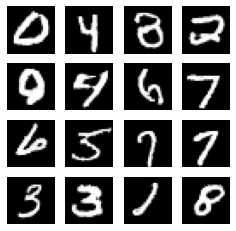

Time for interval 198 is 6.578071594238281 sec
19900 [D loss: 0.224501, r_loss: 0.300488, f_loss: 0.148514, acc.: 94.53%, real_acc:90.62%, fake_acc:98.44%] [G loss: 2.828355]


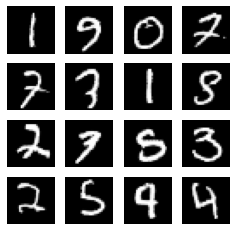

Time for interval 199 is 6.701813459396362 sec
20000 [D loss: 0.208464, r_loss: 0.110942, f_loss: 0.305986, acc.: 93.36%, real_acc:98.44%, fake_acc:88.28%] [G loss: 3.143300]


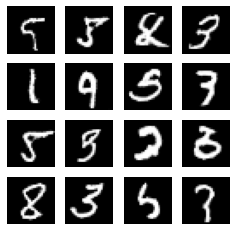

Time for interval 200 is 6.792245388031006 sec


In [13]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 100
# Build models
# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval,use_tf2=use_tf2)

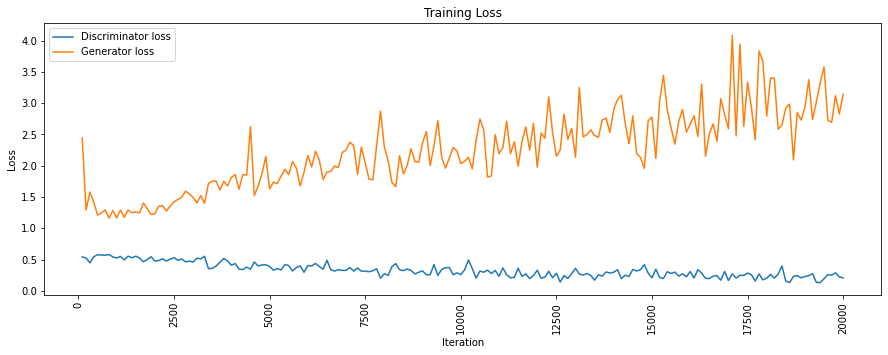

In [14]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

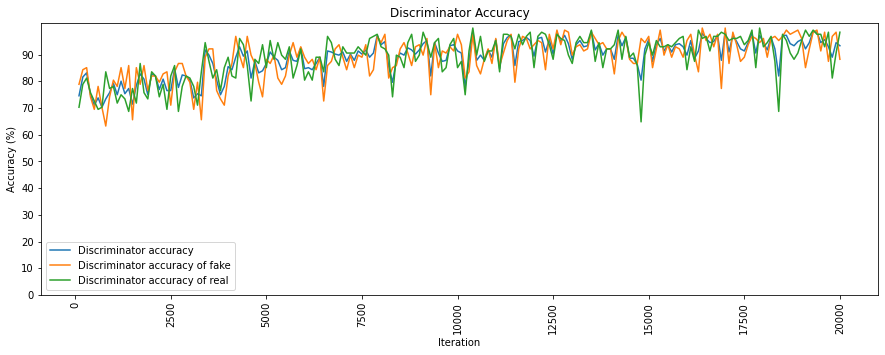

In [17]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")
plt.plot(iteration_checkpoints, f_accuracies, label="Discriminator accuracy of fake")
plt.plot(iteration_checkpoints, r_accuracies, label="Discriminator accuracy of real")

plt.xticks(rotation=90)
plt.yticks(range(0, 100, 10))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

----

1% generated images are predicted as real
[29]
tf.Tensor([[0.71456325]], shape=(1, 1), dtype=float32)


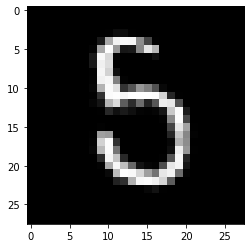

In [20]:
def evaluate(n_sample=100, use_tf2=False):
    # Generate a batch of fake images
    z = np.random.normal(0, 1, (n_sample, 100))

    # Train Discriminator
    if use_tf2:
        gen_imgs = generator(z)
    else: 
        gen_imgs = generator.predict(z)
    real = np.ones((n_sample, 1))
    fake = np.zeros((n_sample, 1))
    a=accuracy(real, discriminator(gen_imgs))
    print ("%d%% generated images are predicted as real"%int(a*100))
    idx=np.argwhere(tf.reshape(discriminator(gen_imgs),-1)>0.5).reshape(-1)
    print (idx)
    for i in idx:
      sel_imgs=gen_imgs[i,:,:,0]
      print(discriminator(gen_imgs[i:i+1]))
      plt.imshow(sel_imgs,cmap='gray')
      plt.show()
    
evaluate(n_sample=100,use_tf2=use_tf2)